In [28]:
import os
import json
import pandas as pd

def load_combined_report_dataframe(json_filename="report.json"):
    # Use relative path (assumes same directory)
    json_path = os.path.join(os.getcwd(), json_filename)

    with open(json_path, "r") as f:
        all_reports = json.load(f)

    records = []

    for key, report in all_reports.items():
        try:
            row_data = {}

            # Merge all relevant sections
            row_data.update(report.get("performance", {}))
            row_data.update(report.get("timing", {}))
            row_data.update(report.get("complexity", {}))

            row_data["iteration"] = int(key)  # add the loop index for row label
            records.append(row_data)
        except Exception as e:
            print(f"Error processing report {key}: {e}")

    df = pd.DataFrame(records).set_index("iteration").sort_index()
    return df

df1 = load_combined_report_dataframe('report1.json')
df2 = load_combined_report_dataframe("report2.json")
df_list = [df1, df2]
df1.head()

,accuracy,error_rate,precision,recall,f1_score,Ingestion_time,Preprocessing train data_time,Training_time,Preprocessing test data_time,Prediction_time,num_trees,avg_depth,avg_leaves,avg_splits
iteration,,,,,,,,,,,,,,
2,0.927723,0.072277,0.912293,0.927723,0.915482,2.1720,0.2904,14.9335,0.3055,0.1590,1,26.0,377.0,300.000000
3,0.927723,0.072277,0.911708,0.927723,0.907244,0.2364,0.1958,11.6645,0.3537,0.2531,2,17.0,210.5,157.500000
4,0.925743,0.074257,0.908712,0.925743,0.909123,0.1945,0.2328,10.9540,0.3675,0.1244,2,20.5,201.5,150.500000
5,0.934653,0.065347,0.928685,0.934653,0.918141,0.2783,0.2177,8.4370,0.4258,0.1839,4,18.5,113.0,80.250000
6,0.930693,0.069307,0.915237,0.930693,0.912611,0.1495,0.2125,7.5715,0.4057,0.2873,3,19.0,146.0,111.666667


In [29]:
def tot_time_col(df) -> pd.DataFrame:
    df['Total_Time'] = df['Ingestion_time'] + df['Preprocessing train data_time'] + df['Training_time'] + df['Preprocessing test data_time'] + df['Prediction_time']  
    return df
df1 = tot_time_col(df1)
df2 = tot_time_col(df2)

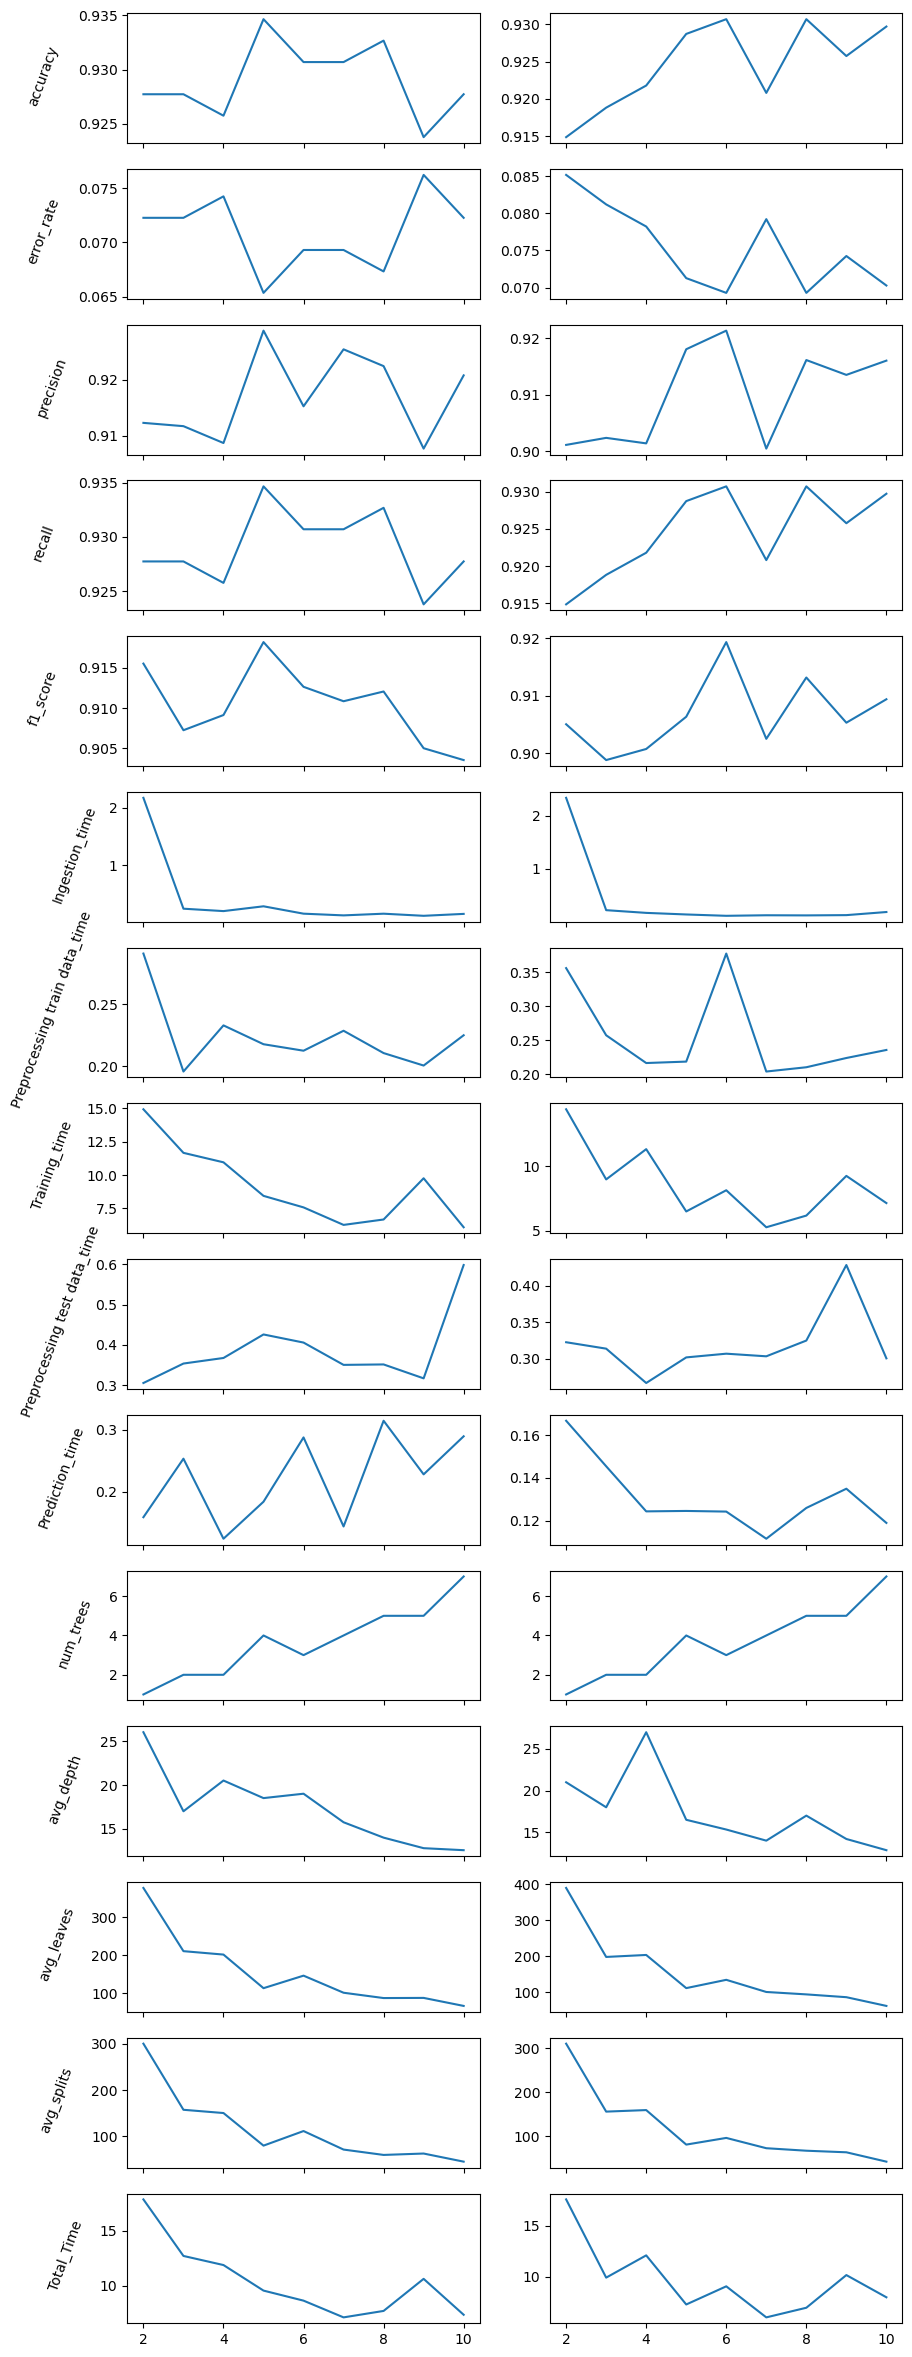

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=len(df_list[0].columns), ncols=len(df_list), sharex=True, figsize=(len(df_list) * 5, len(df1.columns) * 2))

for j, df in enumerate(df_list):
    for i, col in enumerate(df.columns):
        vals = df[col]
        ax[i, j].plot(vals.index, vals.values)
        if j == 0:
            ax[i, j].set_ylabel(col, rotation=70, labelpad=20)
    
plt.savefig(f'all_metrics.png', dpi=300, bbox_inches='tight')